In [1]:
import io
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import export_text
import plotly.graph_objects as go
import seaborn as sns
import os
import shutil
import matplotlib
import re
from sklearn.preprocessing import OneHotEncoder

#Juntar os arquivos

In [2]:
# Fazer upload dos arquivos CSV
arquivos_upload = files.upload()

# Lista para armazenar os DataFrames de cada arquivo CSV
dfs = []

# Iterar sobre os arquivos carregados
for nome_arquivo, conteudo_arquivo in arquivos_upload.items():
    # Ler o arquivo CSV e adicionar ao DataFrame
    df = pd.read_csv(io.BytesIO(conteudo_arquivo), sep=";")
    dfs.append(df)

# Concatenar os DataFrames
#df_final = pd.concat(dfs, ignore_index=True)
#['Identifier','State', 'Qubit', 'Uniform State', 'Dense State', 'Sparsity','Duration','Output Qubit','Output CNot Gate','Output Width', 'Output Depth', 'Preparation Method']

df_00, df_01, df_10, df_11 = [], [], [], []

for data in dfs:
  if (data.loc[0,'Uniform State'] == 0 and data.loc[0,'Dense State'] == 0):
    df_00.append(data)
  elif (data.loc[0,'Uniform State'] == 0 and data.loc[0,'Dense State'] == 1):
    df_01.append(data)
  elif (data.loc[0,'Uniform State'] == 1 and data.loc[0,'Dense State'] == 0):
    df_10.append(data)
  elif (data.loc[0,'Uniform State'] == 1 and data.loc[0,'Dense State'] == 1):
    df_11.append(data)

df_SparseNonUniform = pd.concat(df_00, ignore_index=True)
df_DenseNonUniform = pd.concat(df_01, ignore_index=True)
df_SparseUniform = pd.concat(df_10, ignore_index=True)
df_DenseUniform = pd.concat(df_11, ignore_index=True)

#df_00, df_01, df_10, df_11, dfs = [], [], [], [], []
df_full = pd.concat(dfs, ignore_index=True)
del df_00, df_01, df_10, df_11, dfs

Saving best_lines_DensoNaoUniformedatasetdataset.csv to best_lines_DensoNaoUniformedatasetdataset.csv
Saving best_lines_DensoUniformedatasetdataset.csv to best_lines_DensoUniformedatasetdataset.csv
Saving best_lines_EsparsoNaoUniforme25datasetdataset.csv to best_lines_EsparsoNaoUniforme25datasetdataset.csv
Saving best_lines_EsparsoNaoUniforme50datasetdataset.csv to best_lines_EsparsoNaoUniforme50datasetdataset.csv
Saving best_lines_EsparsoNaoUniforme75datasetdataset.csv to best_lines_EsparsoNaoUniforme75datasetdataset.csv
Saving best_lines_EsparsoUniforme25datasetdataset.csv to best_lines_EsparsoUniforme25datasetdataset.csv
Saving best_lines_EsparsoUniforme50datasetdataset.csv to best_lines_EsparsoUniforme50datasetdataset.csv
Saving best_lines_EsparsoUniforme75datasetdataset.csv to best_lines_EsparsoUniforme75datasetdataset.csv


#Funções de apoio

In [3]:
def onehotsparsity(df):
  nominal_columns = ['Sparsity']
  sparsity_df = pd.get_dummies(df, prefix=nominal_columns, columns=nominal_columns, dtype=int)
  nominal_columns_names = sparsity_df.columns.to_list()
  return sparsity_df

In [4]:
def replace_text_galho(obj): #REMOVE AS LABELS SAMPLE E VALUE DOS GALHOS
    if type(obj) == matplotlib.text.Annotation:
        txt = obj.get_text()
        txt = re.sub("\nsamples[^$]*class","\nclass",txt)
        obj.set_text(txt)
    return obj

def replace_text_raiz(obj): #REMOVE AS LABELS SAMPLE E VALUE DAS RAIZES
  if type(obj) == matplotlib.text.Annotation:
    txt = obj.get_text()
    _lines = txt.splitlines()
    _result = []
    value_index = None
    class_index = None
    for i, _line in enumerate(_lines):
      if "value" in _line:
        value_index = i
      if "class" in _line:
        class_index = i
    assert value_index and class_index
    _result = _lines[:value_index] + _lines[class_index:]
    obj.set_text("\n".join(_result))
  return obj

#Análise do conjunto de dados

In [5]:
# Criar um diretório temporário para salvar as figuras
temp_dir = "./temp_figures/"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# Plotar e salvar cada figura
figuras=[]

#Etapa de construção da Árvore de Decisão

In [6]:
def trainTree(df):
  df = df.drop(["Identifier", "State", "Duration","Output Qubit","Output CNot Gate","Output Depth", "Output Width"],  axis=1)
  X = df.drop("Preparation Method", axis=1)
  y = df["Preparation Method"]

# Supondo que X seja seu conjunto de features e y seja seu conjunto de rótulos

# Cria um modelo de árvore de decisão
  model = DecisionTreeClassifier()

# Usa Leave-One-Out para validação cruzada
  loo = LeaveOneOut()

# Realiza a validação cruzada e faça previsões nos dados de treinamento
  y_pred = cross_val_predict(model, X, y, cv=loo)

# Avalia o desempenho usando métricas de sua escolha

# Acurácia: mede a proporção de instâncias classificadas corretamente em relação ao total de instâncias.
  accuracy = accuracy_score(y, y_pred)

# Precisão: proporção de instâncias positivas previstas corretamente em relação ao total de instâncias previstas como positivas.
#A precisão é útil quando o custo de falsos positivos é alto.
  precision = precision_score(y, y_pred, average='weighted')

# Revocação: mede a proporção de instâncias positivas previstas corretamente em relação ao total de instâncias realmente positivas.
# A revocação é útil quando o custo de falsos negativos é alto.
  recall = recall_score(y, y_pred, average='weighted')

# F1 Score: média harmônica entre precisão e recall, fornecendo um equilíbrio entre as duas métricas e
# é útil quando há um desequilíbrio significativo entre as classes.
  f1 = f1_score(y, y_pred, average='weighted')

# Exibe métricas
  print(f'Acurácia: {accuracy * 100:.2f}%')
  print(f'Precisão: {precision * 100:.2f}%')
  print(f'Recall: {recall * 100:.2f}%')
  print(f'F1 Score: {f1 * 100:.2f}%')

# Modelo final com todo o conjunto de dados
  model.fit(X, y)
  return (model, X)

In [7]:
def gerarFiguraTree(model, X, titulo):
# Adicionando a árvore de decisão à lista de figuras
# Define as dimensões da figura
  fig, ax = plt.subplots(figsize=(24, 16))

# Constrói a árvore a partir do modelo

  plot_tree(model, feature_names=X.columns, class_names=model.classes_, filled=True, rounded=True, impurity=False, proportion=False, max_depth=None)

  plt.title(f'Árvore de Decisão - {titulo}')

  ax.properties()['children'] = [replace_text_raiz(i) for i in ax.properties()['children']]

  ax.properties()['children'] = [replace_text_galho(i) for i in ax.properties()['children']]
  #plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))
  #plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: int(y)))

  figuras.append(fig)

In [8]:
#Lista de Dataframes por tipo de estado
#df_SparseNonUniform
#df_DenseNonUniform
#df_SparseUniform
#df_DenseUniform
#onehotsparsity(df) - Cria um novo df trantando a coluna Sparsity com o Encoding One Hot
#trainTree(df) - cria um modelo a partir de um df
#plot_tree(modelo, titulo) - Plota a arvore decisão

In [9]:
#modeloTreinado = trainTree(onehotsparsity(df_DenseUniform))
#gerarFiguraTree(model=modeloTreinado[0], X=modeloTreinado[1] , titulo="Estado Uniforme Denso")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acurácia: 82.73%
Precisão: 85.83%
Recall: 82.73%
F1 Score: 82.75%


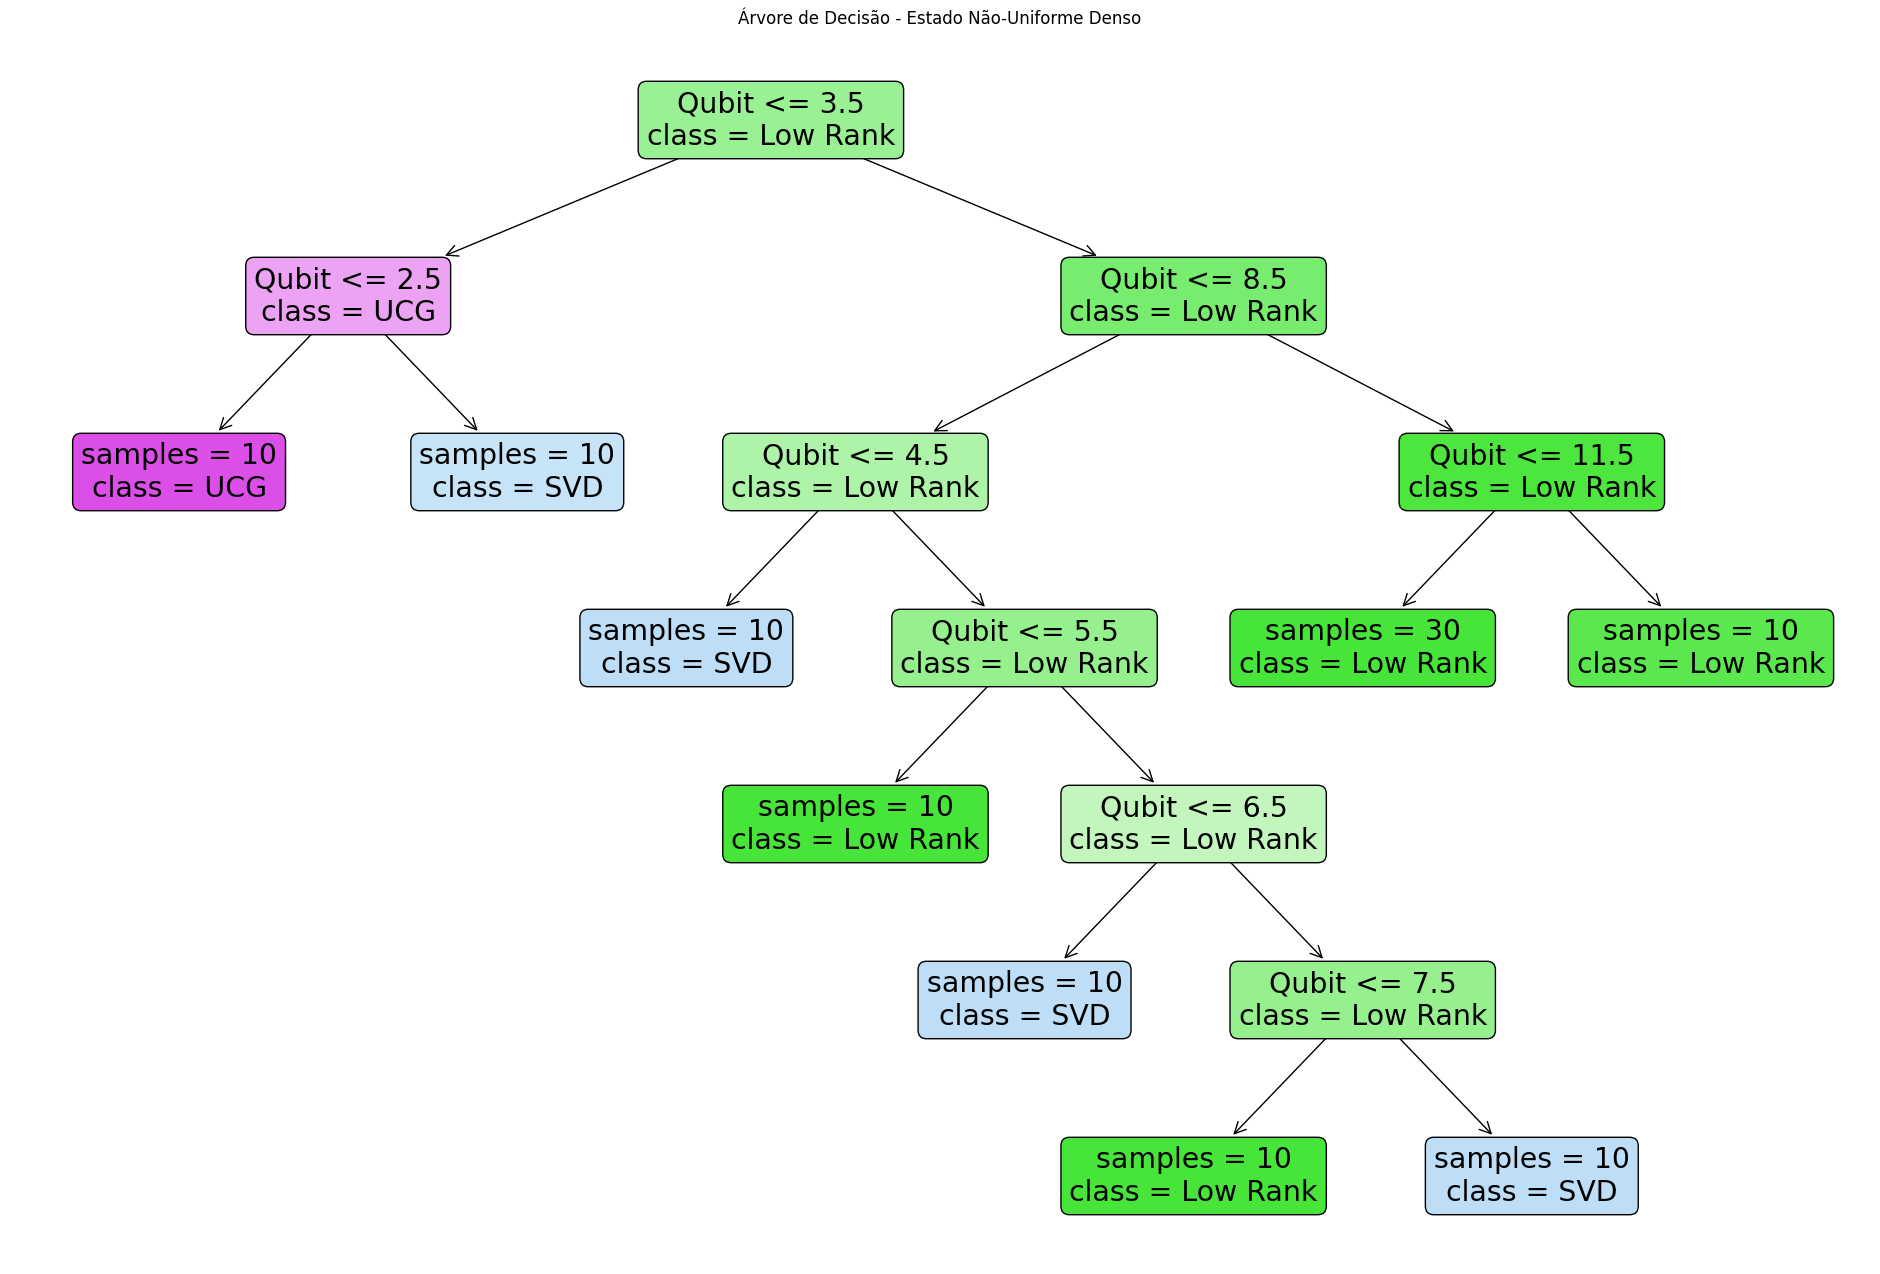

In [10]:
#modeloTreinado = trainTree(onehotsparsity(df_DenseNonUniform))
modeloTreinado = trainTree((df_DenseNonUniform))
modeloTreinadoDenseNonUniform = modeloTreinado[0]
gerarFiguraTree(model=modeloTreinado[0], X=modeloTreinado[1] , titulo="Estado Não-Uniforme Denso")

Acurácia: 86.97%
Precisão: 84.93%
Recall: 86.97%
F1 Score: 85.66%


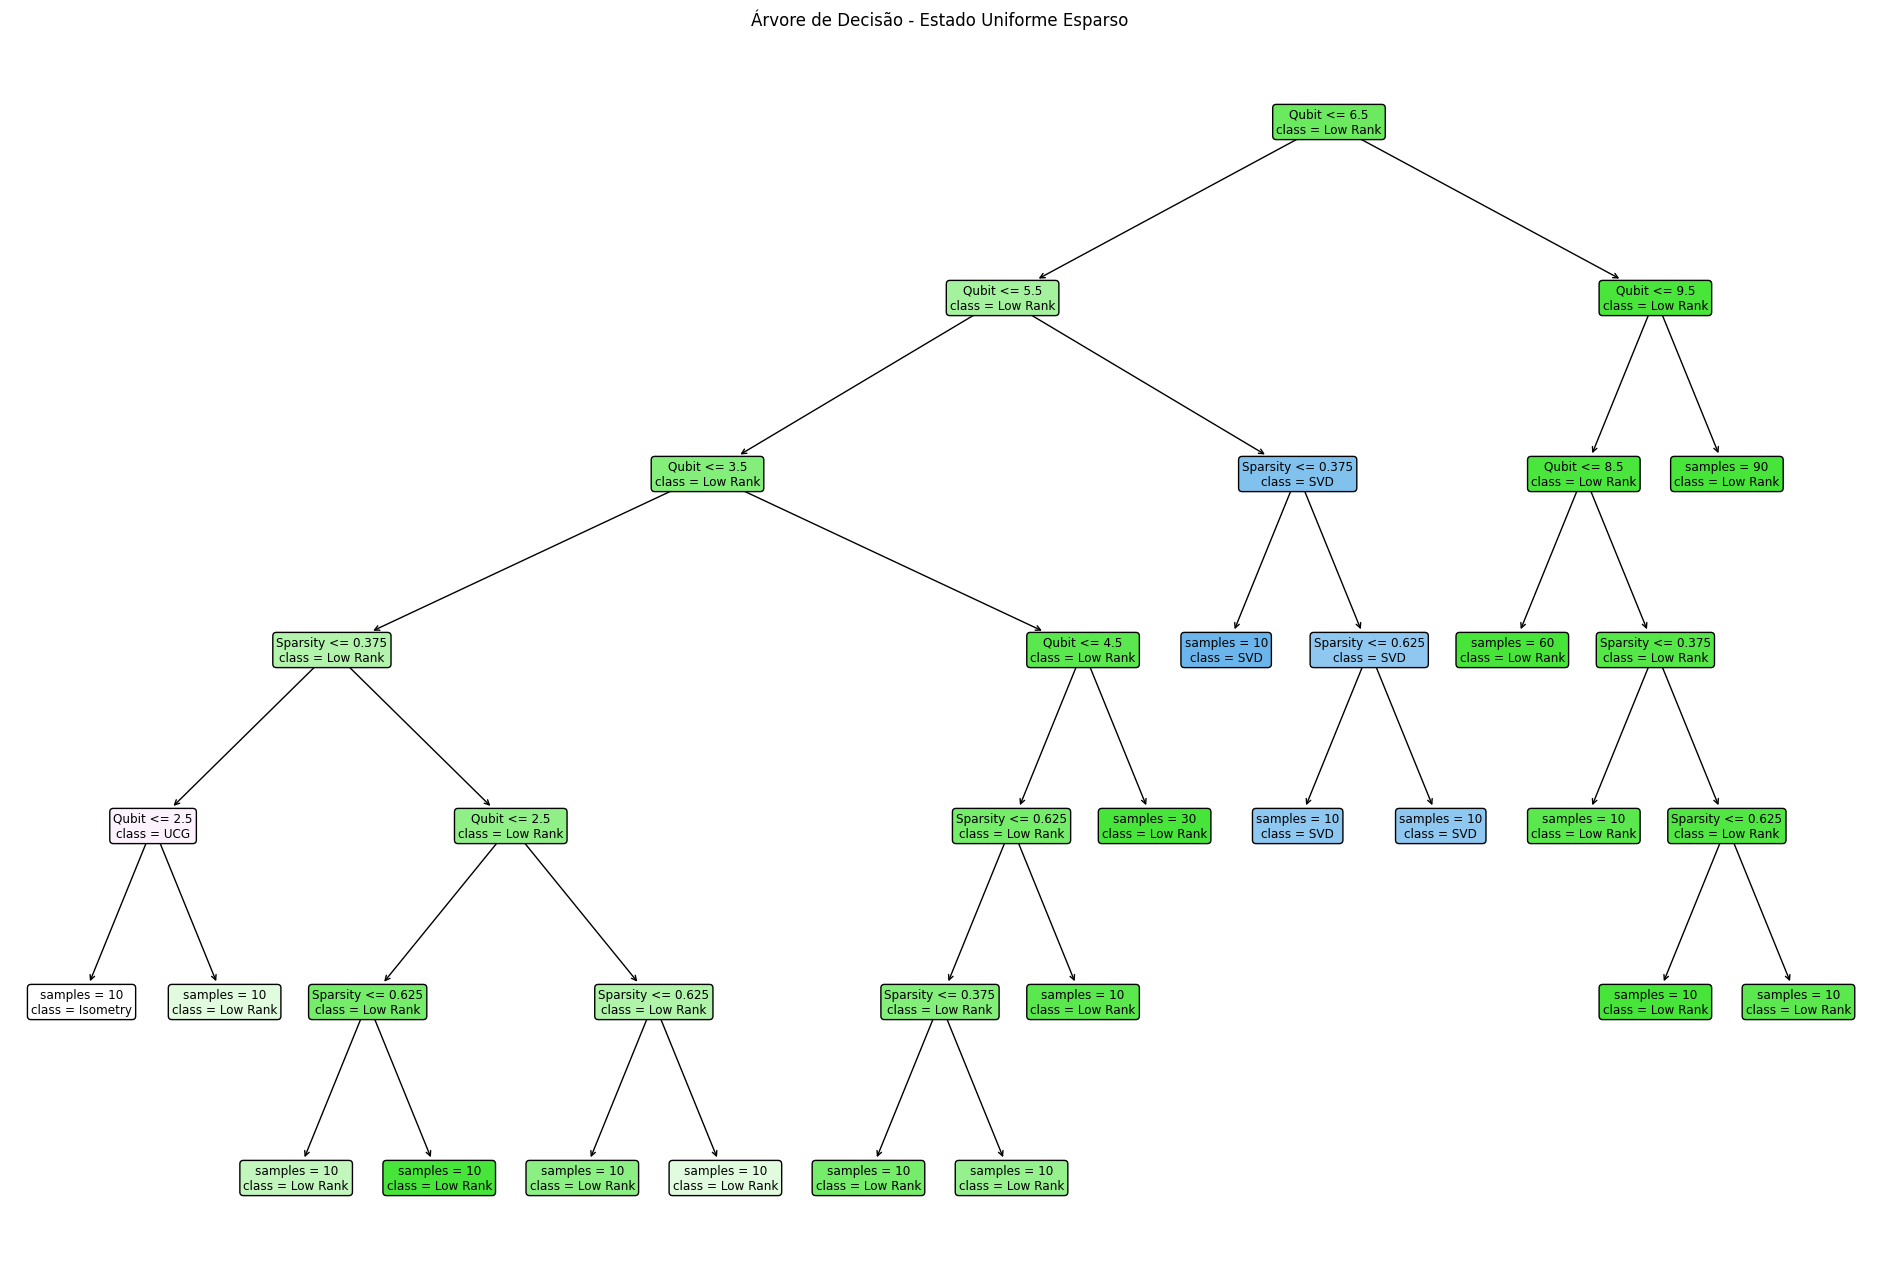

In [11]:
#modeloTreinado = trainTree(onehotsparsity(df_SparseUniform))
modeloTreinado = trainTree((df_SparseUniform))
modeloTreinadoSparseUniform = modeloTreinado[0]
gerarFiguraTree(model=modeloTreinado[0], X=modeloTreinado[1] , titulo="Estado Uniforme Esparso")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acurácia: 76.06%
Precisão: 73.79%
Recall: 76.06%
F1 Score: 74.89%


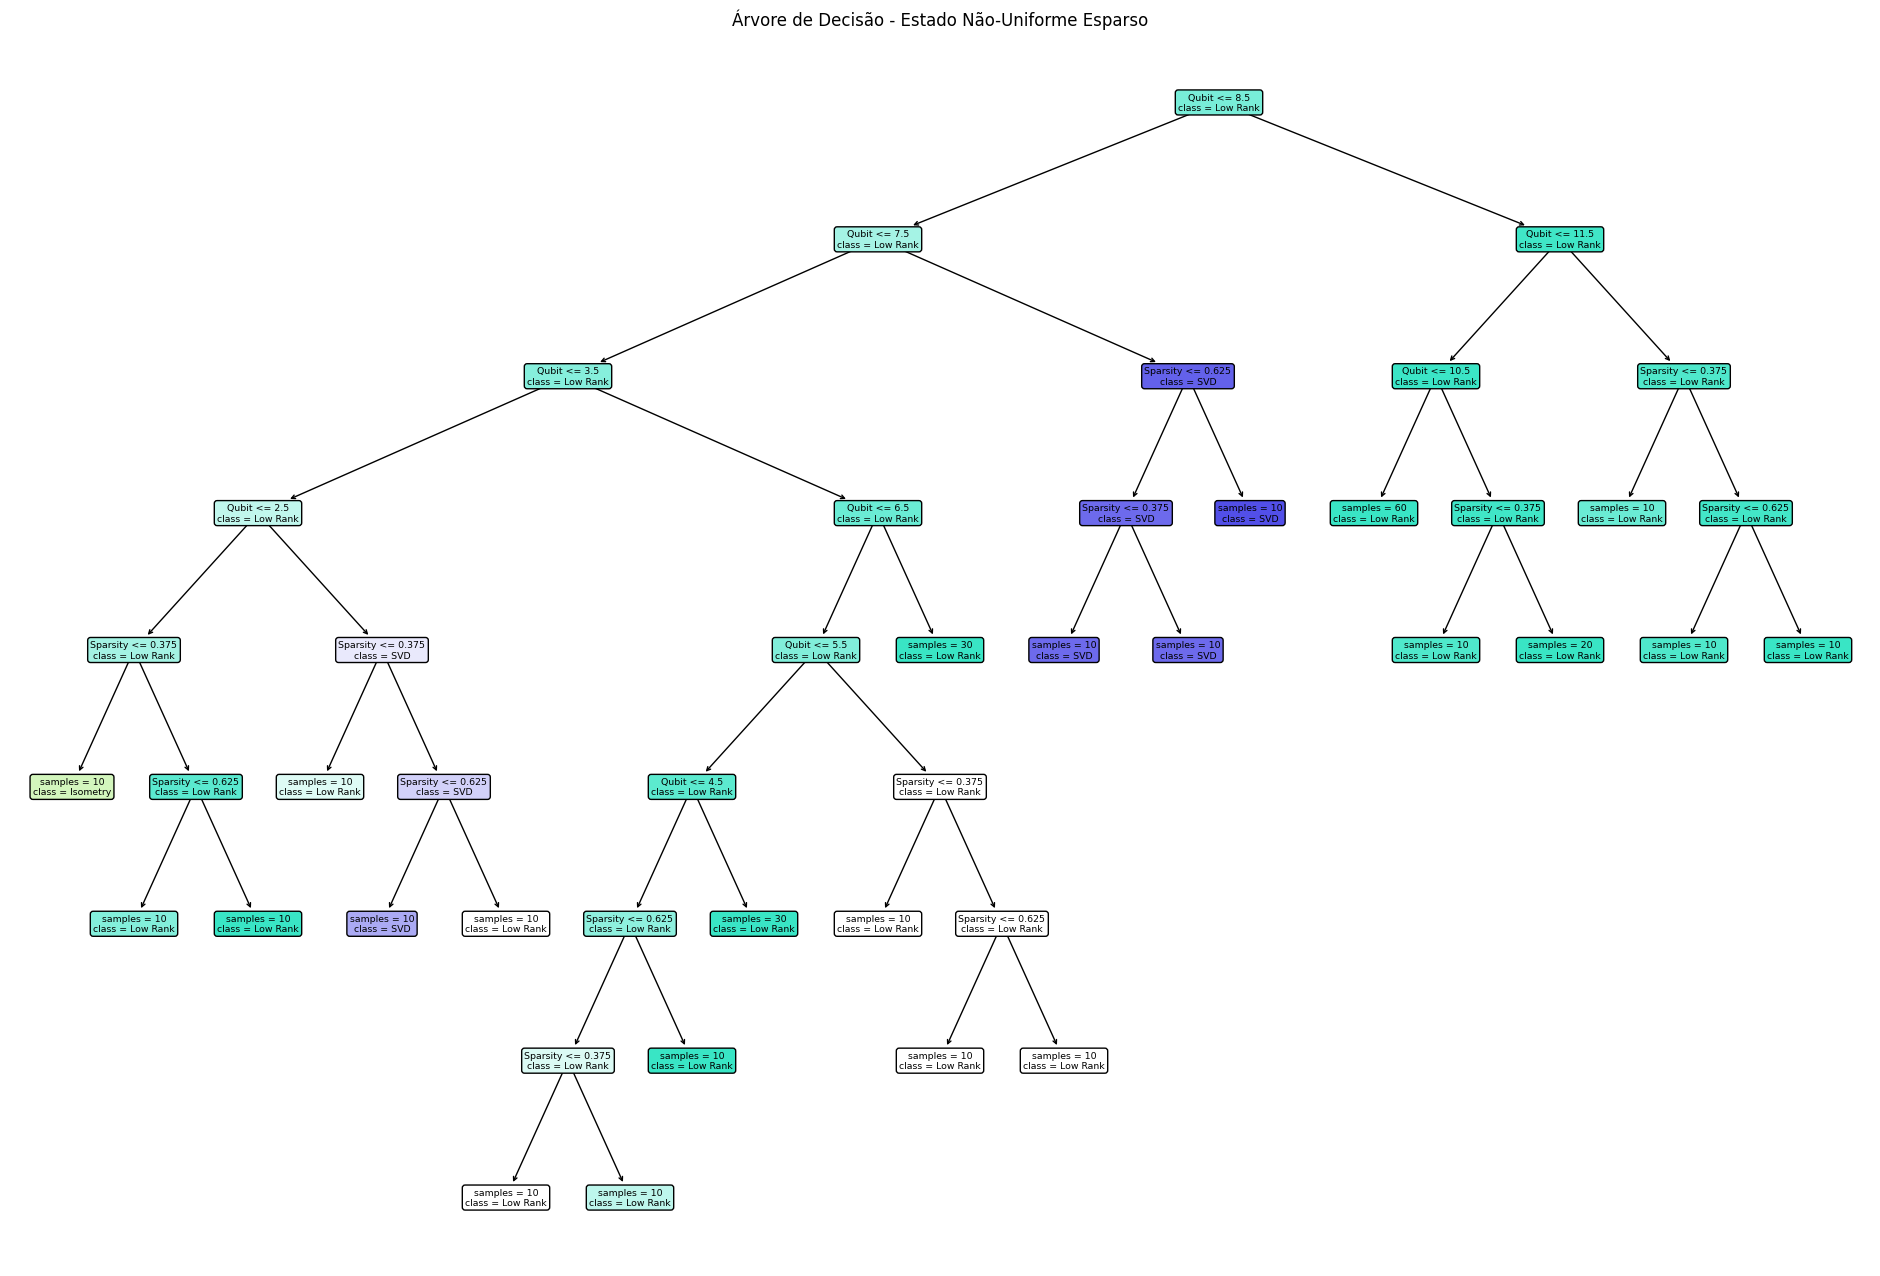

In [12]:
#modeloTreinado = trainTree(onehotsparsity(df_SparseNonUniform))
modeloTreinado = trainTree((df_SparseNonUniform))
modeloTreinadoSparseNonUniform = modeloTreinado[0]
gerarFiguraTree(model=modeloTreinado[0], X=modeloTreinado[1] , titulo="Estado Não-Uniforme Esparso")

In [14]:
#modeloTreinado = trainTree(onehotsparsity(df_full))
modeloTreinado = trainTree((df_DenseUniform))
modeloTreinadoDenseUniform = modeloTreinado[0]
#gerarFiguraTree(model=modeloTreinado[0], X=modeloTreinado[1] , titulo="Denso Uniforme")

Acurácia: 100.00%
Precisão: 100.00%
Recall: 100.00%
F1 Score: 100.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acurácia: 83.98%
Precisão: 83.24%
Recall: 83.98%
F1 Score: 83.48%


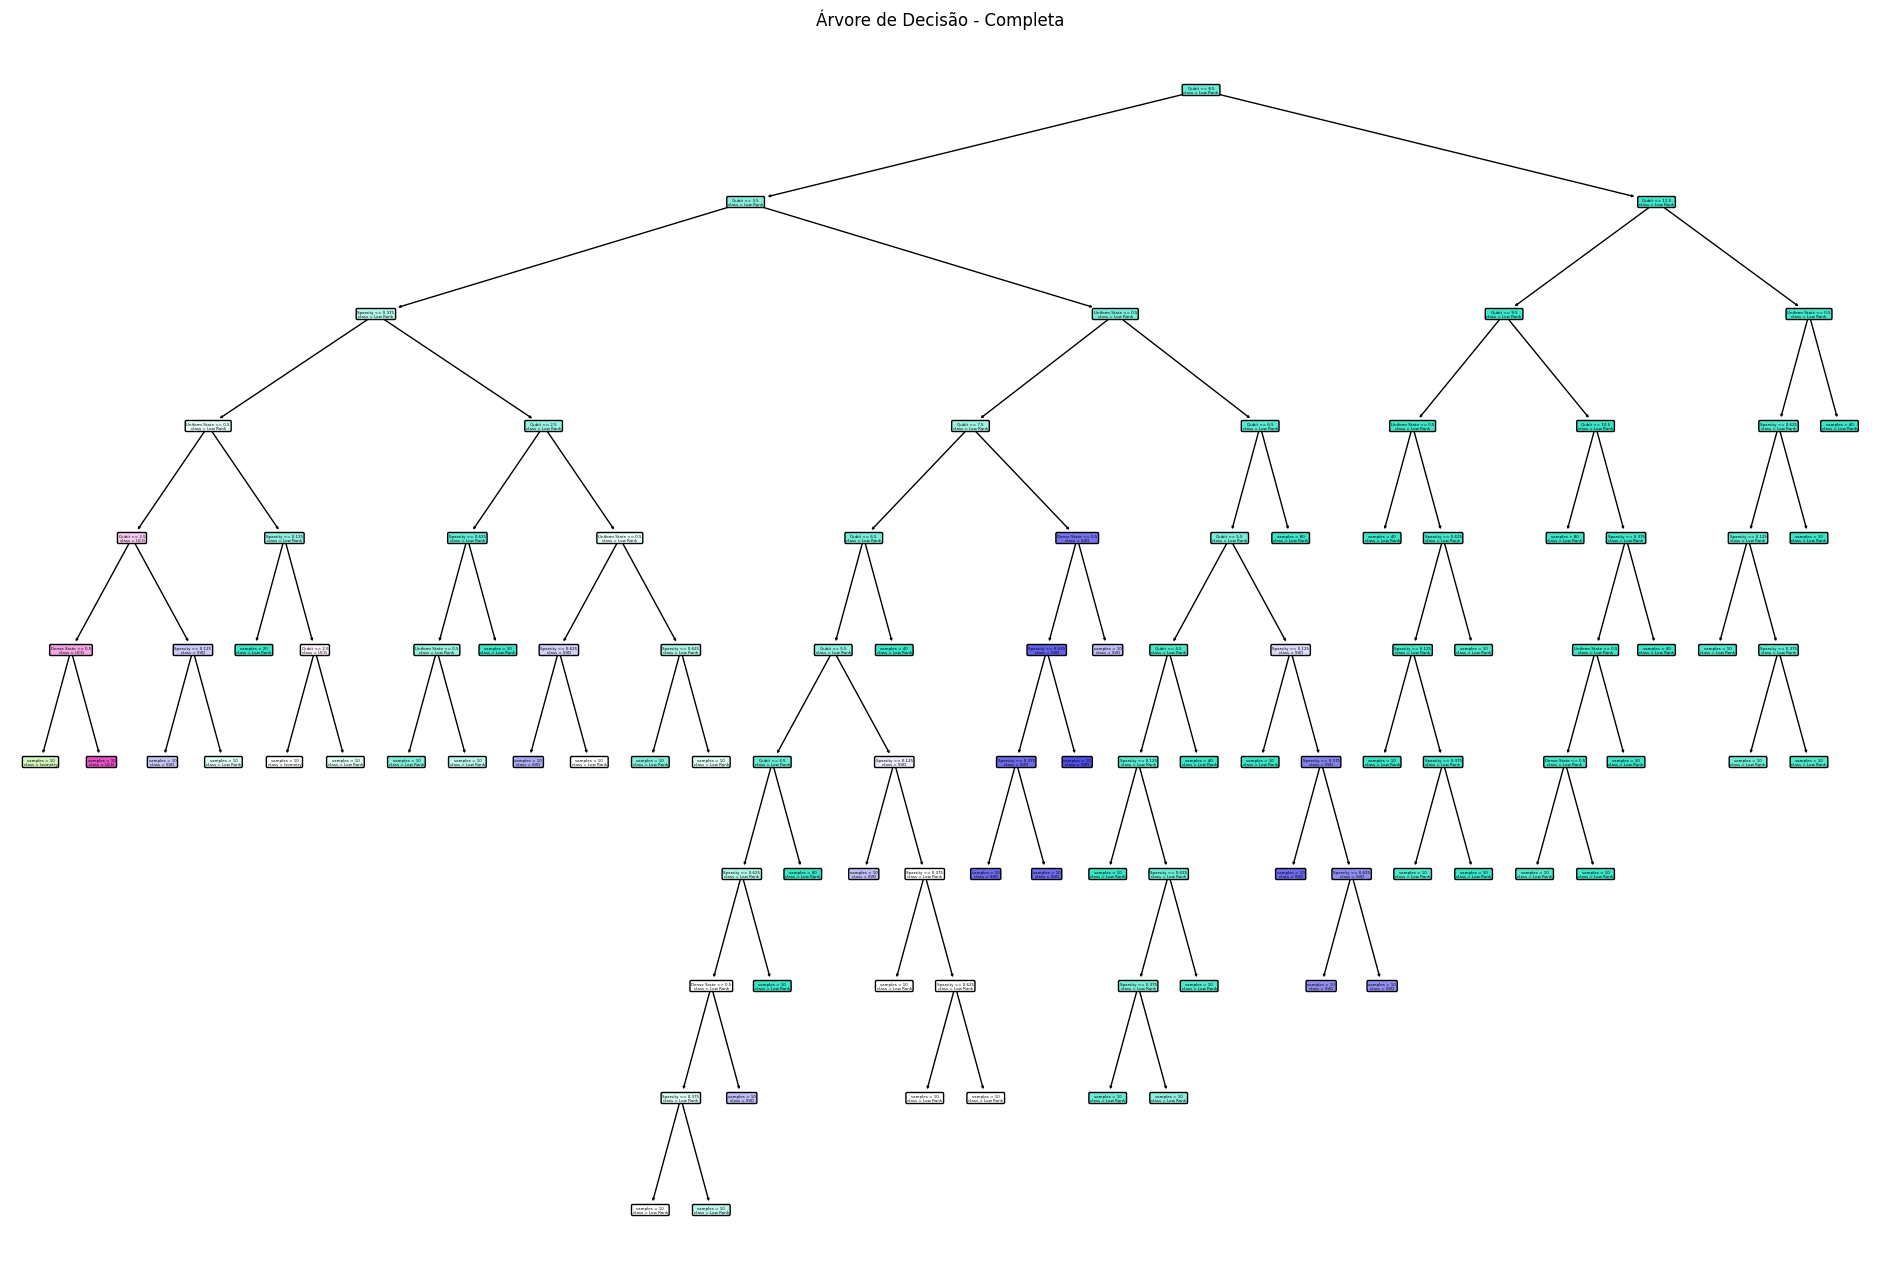

In [15]:
#modeloTreinado = trainTree(onehotsparsity(df_full))
modeloTreinado = trainTree((df_full))
modeloTreinadoFULL = modeloTreinado[0]
gerarFiguraTree(model=modeloTreinado[0], X=modeloTreinado[1] , titulo="Completa")

# Avaliação de cada Árvore de Decisão

In [16]:
# Fazer upload dos arquivos CSV
arquivos_upload = files.upload()

# Lista para armazenar os DataFrames de cada arquivo CSV
dfs = []

# Iterar sobre os arquivos carregados
for nome_arquivo, conteudo_arquivo in arquivos_upload.items():
    # Ler o arquivo CSV e adicionar ao DataFrame
    df = pd.read_csv(io.BytesIO(conteudo_arquivo), sep=";")
    dfs.append(df)

# Concatenar os DataFrames
#df_final = pd.concat(dfs, ignore_index=True)
#['Identifier','State', 'Qubit', 'Uniform State', 'Dense State', 'Sparsity','Duration','Output Qubit','Output CNot Gate','Output Width', 'Output Depth', 'Preparation Method']

df_00, df_01, df_10, df_11 = [], [], [], []

for data in dfs:
  if (data.loc[0,'Uniform State'] == 0 and data.loc[0,'Dense State'] == 0):
    df_00.append(data)
  elif (data.loc[0,'Uniform State'] == 0 and data.loc[0,'Dense State'] == 1):
    df_01.append(data)
  elif (data.loc[0,'Uniform State'] == 1 and data.loc[0,'Dense State'] == 0):
    df_10.append(data)
  elif (data.loc[0,'Uniform State'] == 1 and data.loc[0,'Dense State'] == 1):
    df_11.append(data)

t_df_SparseNonUniform = pd.concat(df_00, ignore_index=True)
t_df_DenseNonUniform = pd.concat(df_01, ignore_index=True)
t_df_SparseUniform = pd.concat(df_10, ignore_index=True)
t_df_DenseUniform = pd.concat(df_11, ignore_index=True)

#df_00, df_01, df_10, df_11, dfs = [], [], [], [], []
t_df_full = pd.concat(dfs, ignore_index=True)
del df_00, df_01, df_10, df_11, dfs

Saving best_lines_DenseNonUniformStatedatasetdataset.csv to best_lines_DenseNonUniformStatedatasetdataset.csv
Saving best_lines_DenseUniformStatedatasetdataset.csv to best_lines_DenseUniformStatedatasetdataset.csv
Saving best_lines_SparseNonUniformStat_25datasetdataset.csv to best_lines_SparseNonUniformStat_25datasetdataset.csv
Saving best_lines_SparseNonUniformStat_50datasetdataset.csv to best_lines_SparseNonUniformStat_50datasetdataset.csv
Saving best_lines_SparseNonUniformStat_75datasetdataset.csv to best_lines_SparseNonUniformStat_75datasetdataset.csv
Saving best_lines_SparseUniformStat_50datasetdataset.csv to best_lines_SparseUniformStat_50datasetdataset.csv
Saving best_lines_SparseUniformState_25datasetdataset.csv to best_lines_SparseUniformState_25datasetdataset.csv
Saving best_lines_SparseUniformState_75datasetdataset.csv to best_lines_SparseUniformState_75datasetdataset.csv


In [17]:
#modeloTreinadoDenseNonUniform
#modeloTreinadoSparseUniform
#modeloTreinadoSparseNonUniform
#modeloTreinadoDenseUniform
#modeloTreinadoFULL

def validador(modelo, df):
  df = df.drop(["Identifier", "State", "Duration","Output Qubit","Output CNot Gate","Output Depth", "Output Width"],  axis=1)
  X = df.drop("Preparation Method", axis=1)
  y = df["Preparation Method"]

  y_pred = modelo.predict(X)

  # Avalia o desempenho usando métricas de sua escolha

# Acurácia: mede a proporção de instâncias classificadas corretamente em relação ao total de instâncias.
  accuracy = accuracy_score(y, y_pred)

# Precisão: proporção de instâncias positivas previstas corretamente em relação ao total de instâncias previstas como positivas.
#A precisão é útil quando o custo de falsos positivos é alto.
  precision = precision_score(y, y_pred, average='weighted')

# Revocação: mede a proporção de instâncias positivas previstas corretamente em relação ao total de instâncias realmente positivas.
# A revocação é útil quando o custo de falsos negativos é alto.
  recall = recall_score(y, y_pred, average='weighted')

# F1 Score: média harmônica entre precisão e recall, fornecendo um equilíbrio entre as duas métricas e
# é útil quando há um desequilíbrio significativo entre as classes.
  f1 = f1_score(y, y_pred, average='weighted')

# Exibe métricas
  print(f'Acurácia: {accuracy * 100:.2f}%')
  print(f'Precisão: {precision * 100:.2f}%')
  print(f'Recall: {recall * 100:.2f}%')
  print(f'F1 Score: {f1 * 100:.2f}%')

In [19]:
validador(modeloTreinadoDenseNonUniform, t_df_DenseNonUniform)

Acurácia: 85.45%
Precisão: 91.27%
Recall: 85.45%
F1 Score: 86.53%


In [20]:
validador(modeloTreinadoSparseUniform, t_df_SparseUniform)

Acurácia: 83.94%
Precisão: 81.71%
Recall: 83.94%
F1 Score: 82.43%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
validador(modeloTreinadoSparseNonUniform, t_df_SparseNonUniform)

Acurácia: 76.97%
Precisão: 73.80%
Recall: 76.97%
F1 Score: 74.13%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
validador(modeloTreinadoDenseUniform, t_df_DenseUniform)

Acurácia: 100.00%
Precisão: 100.00%
Recall: 100.00%
F1 Score: 100.00%


In [23]:
validador(modeloTreinadoFULL, t_df_full)

Acurácia: 83.52%
Precisão: 84.76%
Recall: 83.52%
F1 Score: 82.95%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Salvar todas as figuras em PDF
for i, fig in enumerate(figuras, 1):
    fig_path = os.path.join(temp_dir, f"figura_{i}.pdf")
    fig.savefig(fig_path)
    plt.close(fig)  # Fechar a figura após salvar para liberar memória

# Compactar todos os arquivos em um arquivo ZIP
shutil.make_archive("./figurasArvores", 'zip', temp_dir)

# Baixar o arquivo ZIP
files.download("./figurasArvores.zip")

# Excluir o diretório temporário
shutil.rmtree(temp_dir)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>